In [1]:
!pip install tifffile


In [92]:
import os
import glob
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt

IMAGE_ROOT = '/kaggle/input/water-segmentation-images/images-20250919T154810Z-1-001'
MASK_ROOT = '/kaggle/input/water-segmentation-masks/labels-20250919T154815Z-1-001'



In [93]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 12
NUM_CLASSES = 1 
BATCH_SIZE = 16
EPOCHS = 25 

def get_file_paths(image_dir, mask_dir):

    image_files = sorted(glob.glob(os.path.join(image_dir, '**', '*.tif*'), recursive=True))
    mask_files = sorted(glob.glob(os.path.join(mask_dir, '**', '*.png*'), recursive=True))

    image_dict = {os.path.splitext(os.path.basename(f))[0]: f for f in image_files}
    mask_dict = {os.path.splitext(os.path.basename(f))[0]: f for f in mask_files}
    common_keys = sorted(list(set(image_dict.keys()) & set(mask_dict.keys())))

    image_paths = [image_dict[key] for key in common_keys]
    mask_paths = [mask_dict[key] for key in common_keys]

    if not image_paths or not mask_paths:
        print("Warning: No matching image and mask files found. Please check paths.")
        return [], []
    
    return image_paths, mask_paths

def load_data(image_paths, mask_paths):
    images = []
    masks = []
    for i in range(len(image_paths)):
        try:
            img = Image.open(image_paths[i])
            img_array = np.array(img).astype(np.float32)
            if img_array.ndim == 2:
                img_array = np.expand_dims(img_array, axis=-1)
            elif img_array.ndim == 3 and img_array.shape[2] != IMG_CHANNELS:
                 img_array = np.repeat(np.expand_dims(img_array[:, :, 0], axis=-1), IMG_CHANNELS, axis=-1)
            images.append(img_array / 65535.0)
            mask = Image.open(mask_paths[i]).convert('L') 
            mask_array = np.array(mask).astype(np.float32) / 255.0
            masks.append(np.expand_dims(mask_array, axis=-1))

        except Exception as e:
            print(f"Error loading file {image_paths[i]} or {mask_paths[i]}: {e}")
            continue

    images = np.array(images)
    masks = np.array(masks)
    
    return images, masks

In [94]:
def visualize_sample(images, masks):
    if images.shape[0] == 0:
        print("No data to visualize.")
        return
        
    sample_idx = np.random.randint(0, images.shape[0])
    sample_image = images[sample_idx]
    sample_mask = masks[sample_idx]

    plt.figure(figsize=(20, 10))
    plt.suptitle('Sample Image Bands and Corresponding Mask', fontsize=16)

    for i in range(min(4, IMG_CHANNELS)):
        plt.subplot(2, 3, i + 1)
        plt.imshow(sample_image[:, :, i], cmap='gray')
        plt.title(f'Band {i+1}')
        plt.axis('off')

    plt.subplot(2, 3, 5)
    plt.imshow(sample_image[:, :, :3]) 
    plt.title('RGB Composite')
    plt.axis('off')

    plt.subplot(2, 3, 6)
    plt.imshow(np.squeeze(sample_mask), cmap='gray')
    plt.title('Ground Truth Mask')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [95]:
def mean_iou(y_true, y_pred):
    y_pred = K.cast(y_pred > 0.5, dtype='float32')
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    iou = (intersection + K.epsilon()) / (union + K.epsilon())
    return iou

precision_metric = tf.keras.metrics.Precision(name='precision_metric')
recall_metric = tf.keras.metrics.Recall(name='recall_metric')

def f1_score(y_true, y_pred):
    """Custom F1-score metric."""
    y_pred = K.cast(y_pred > 0.5, dtype='float32')
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1

In [88]:
def build_unet(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    inputs = Input(input_shape)
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D()(conv1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D()(conv2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D()(conv3)
    conv4 = Conv2D(256, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, 3, activation='relu', padding='same')(conv4)
    up5 = concatenate([UpSampling2D()(conv4), conv3], axis=-1)
    conv5 = Conv2D(128, 3, activation='relu', padding='same')(up5)
    conv5 = Conv2D(128, 3, activation='relu', padding='same')(conv5)
    up6 = concatenate([UpSampling2D()(conv5), conv2], axis=-1)
    conv6 = Conv2D(64, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(64, 3, activation='relu', padding='same')(conv6)
    up7 = concatenate([UpSampling2D()(conv6), conv1], axis=-1)
    conv7 = Conv2D(32, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(32, 3, activation='relu', padding='same')(conv7)
    outputs = Conv2D(NUM_CLASSES, 1, activation='sigmoid')(conv7)
    return Model(inputs, outputs)
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_96 (Conv2D)  │ (None, 128, 128,  │      6,976 │ input_layer_6[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_97 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_96[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_18    │ (None, 64, 64,    │          0 │ conv2d_97[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_98 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_18… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_99 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_98[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_19    │ (None, 32, 32,    │          0 │ conv2d_99[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_100 (Conv2D) │ (None, 32, 32,    │    295,168 │ max_pooling2d_19… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_101 (Conv2D) │ (None, 32, 32,    │    590,080 │ conv2d_100[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_20    │ (None, 16, 16,    │          0 │ conv2d_101[0][0]  │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_102 (Conv2D) │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_20… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_103 (Conv2D) │ (None, 16, 16,    │  2,359,808 │ conv2d_102[0][0]  │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_18    │ (None, 32, 32,    │          0 │ conv2d_103[0][0]  │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_104 (Conv2D) │ (None, 32, 32,    │    524,544 │ up_sampling2d_18… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_18      │ (None, 32, 32,    │          0 │ conv2d_104[0][0], │
│ (Concatenate)       │ 512)              │            │ conv2d_101[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_105 (Conv2D) │ (None, 32, 32,    │  1,179,904 │ concatenate_18[0… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_106 (Conv2D) │ (None, 32, 32,    │    590,080 │ conv2d_105[0][0]

 Total params: 23,107,589 (88.15 MB)

 Trainable params: 7,702,529 (29.38 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 15,405,060 (58.77 MB)

Training data shape: (244, 128, 128, 12)
Validation data shape: (62, 128, 128, 12)


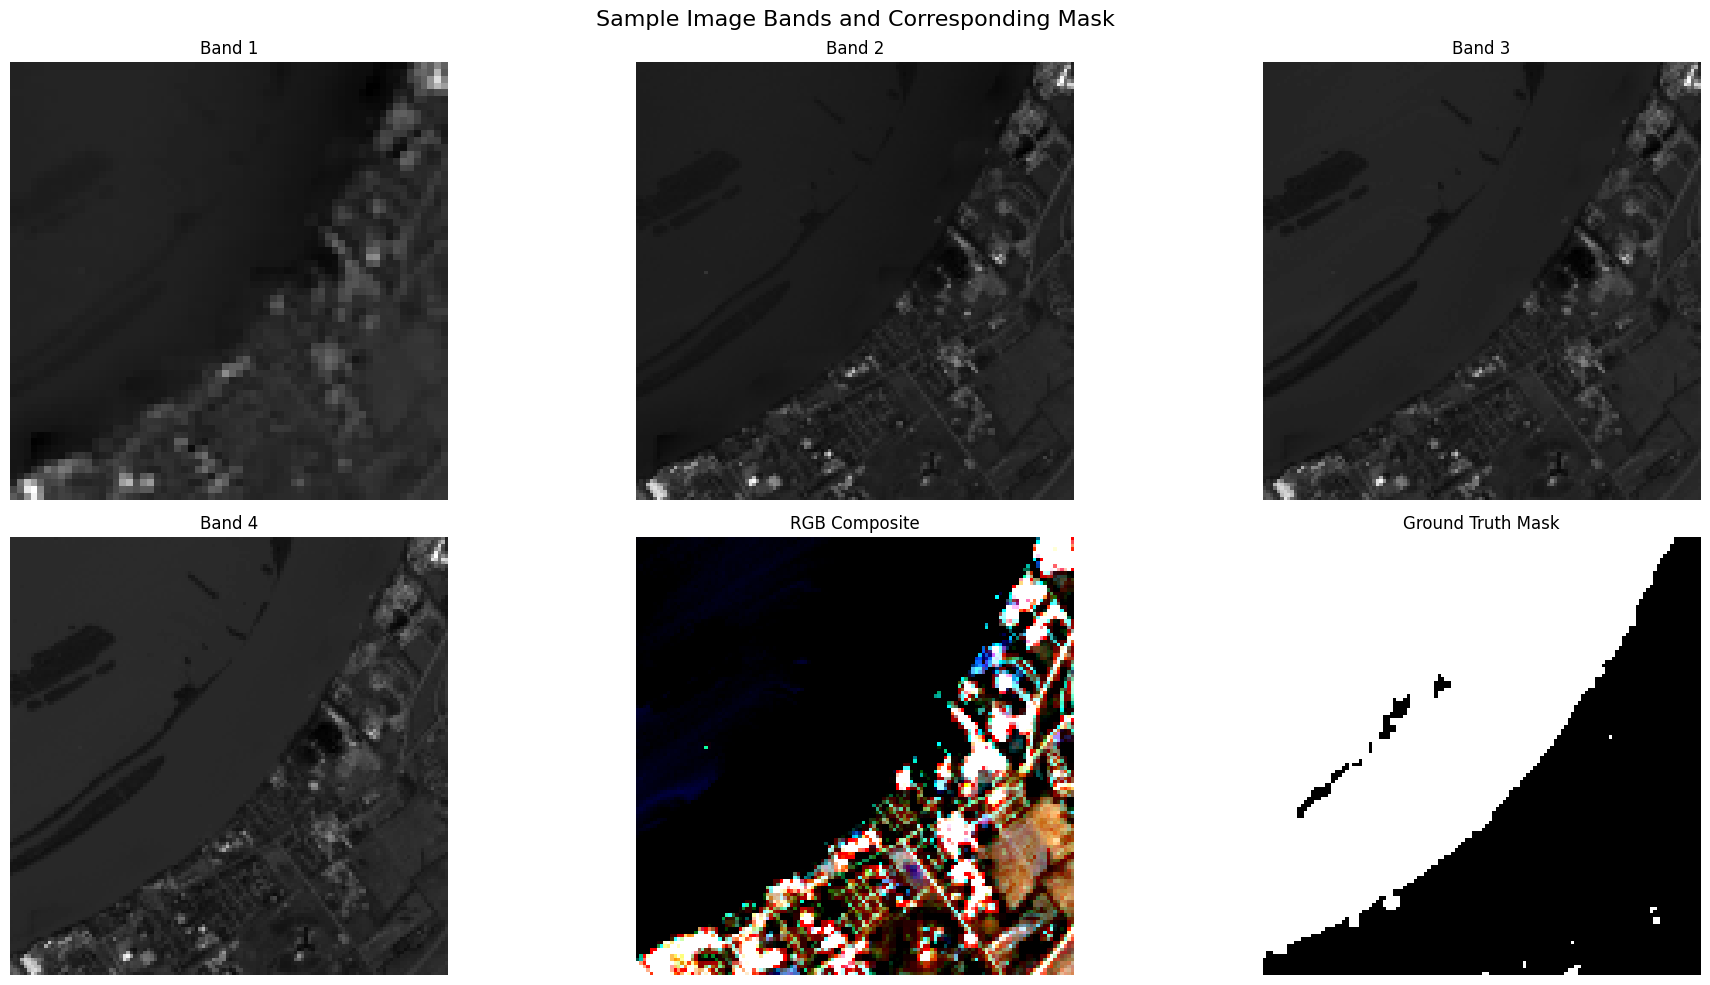

In [96]:
    X_train, X_val, y_train, y_val = train_test_split(
        images, masks, test_size=0.2, random_state=42
    )
    print(f"Training data shape: {X_train.shape}")
    print(f"Validation data shape: {X_val.shape}")

    # Visualize a random sample
    visualize_sample(X_train, y_train)

    # Build and compile the U-Net model
    model = build_unet(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    model.compile(optimizer='adam', 
                  loss='binary_crossentropy', 
                  metrics=[mean_iou, precision_metric, recall_metric, f1_score])
    
    

In [97]:
    history = model.fit(
        X_train, y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(X_val, y_val),
        verbose=1
    )

Epoch 1/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 23s 905ms/step - f1_score: 0.3689 - loss: 0.7870 - mean_iou: 0.2489 - precision_metric: 0.4456 - recall_metric: 0.4859 - val_f1_score: 0.5196 - val_loss: 0.4520 - val_mean_iou: 0.3547 - val_precision_metric: 0.9743 - val_recall_metric: 0.3476
Epoch 2/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - f1_score: 0.5317 - loss: 0.4588 - mean_iou: 0.3668 - precision_metric: 0.8919 - recall_metric: 0.3856 - val_f1_score: 0.6845 - val_loss: 0.3432 - val_mean_iou: 0.5229 - val_precision_metric: 0.8623 - val_recall_metric: 0.5739
Epoch 3/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - f1_score: 0.6840 - loss: 0.3613 - mean_iou: 0.5207 - precision_metric: 0.8627 - recall_metric: 0.5739 - val_f1_score: 0.7153 - val_loss: 0.2767 - val_mean_iou: 0.5606 - val_precision_metric: 0.8447 - val_recall_metric: 0.6320
Epoch 4/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - f1_score: 0.7271 - loss: 0.3111 - mean_iou: 0.5754 - precision_metric: 0.8160 - recall_metric: 0.6708 - val_

In [98]:
    print("\nEvaluating model on validation data...")
    loss, iou, precision, recall, f1 = model.evaluate(X_val, y_val)
    
    print(f"\nFinal Validation Metrics:")
    print(f"  Loss: {loss:.4f}")
    print(f"  Mean IoU: {iou:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")


Evaluating model on validation data...
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step - f1_score: 0.8719 - loss: 0.1341 - mean_iou: 0.7731 - precision_metric: 0.9244 - recall_metric: 0.8278

Final Validation Metrics:
  Loss: 0.1373
  Mean IoU: 0.7792
  Precision: 0.9281
  Recall: 0.8332
  F1-Score: 0.8758


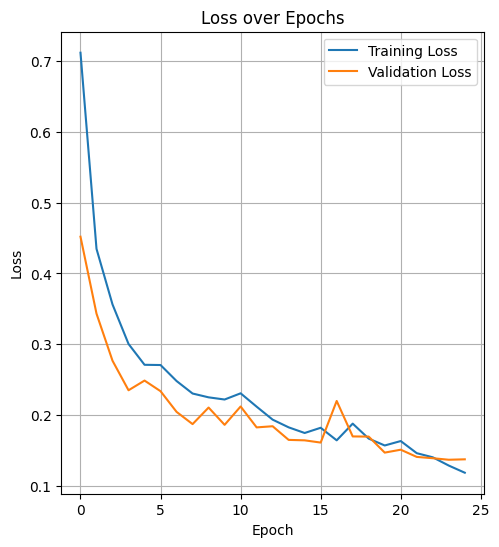

In [99]:
    # Plotting training history for analysis
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

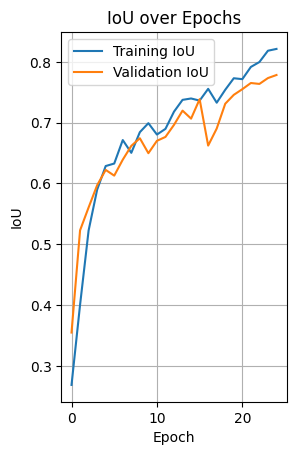

In [100]:
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mean_iou'], label='Training IoU')
    plt.plot(history.history['val_mean_iou'], label='Validation IoU')
    plt.title('IoU over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend()
    plt.grid(True)
    plt.show()


Visualizing a few predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


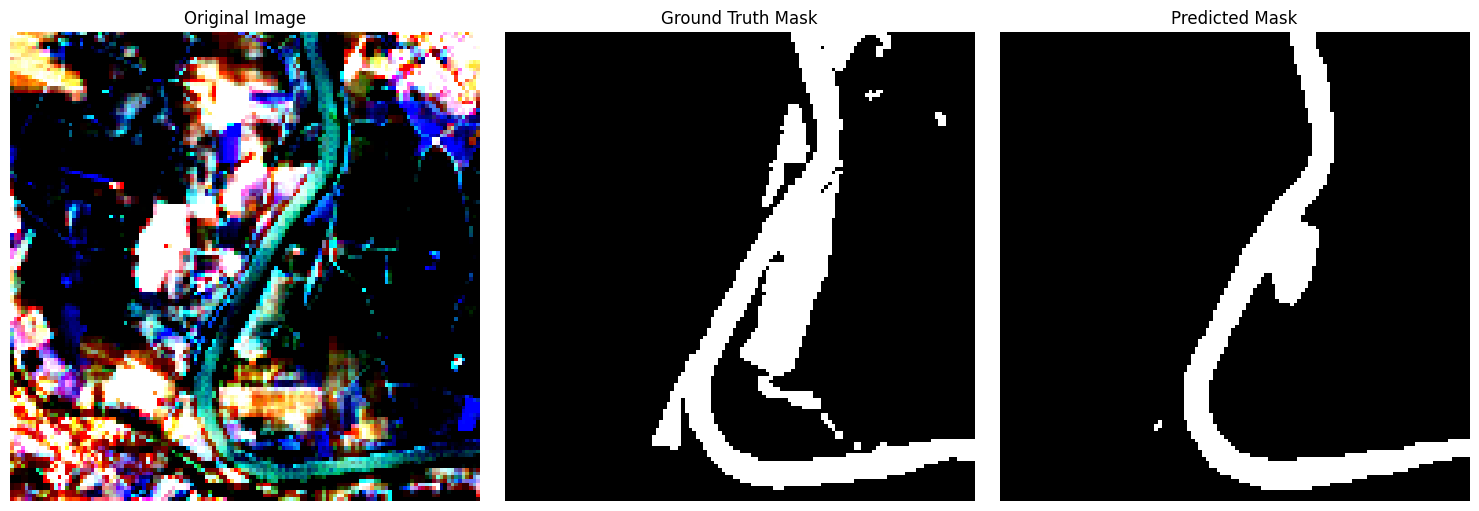

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


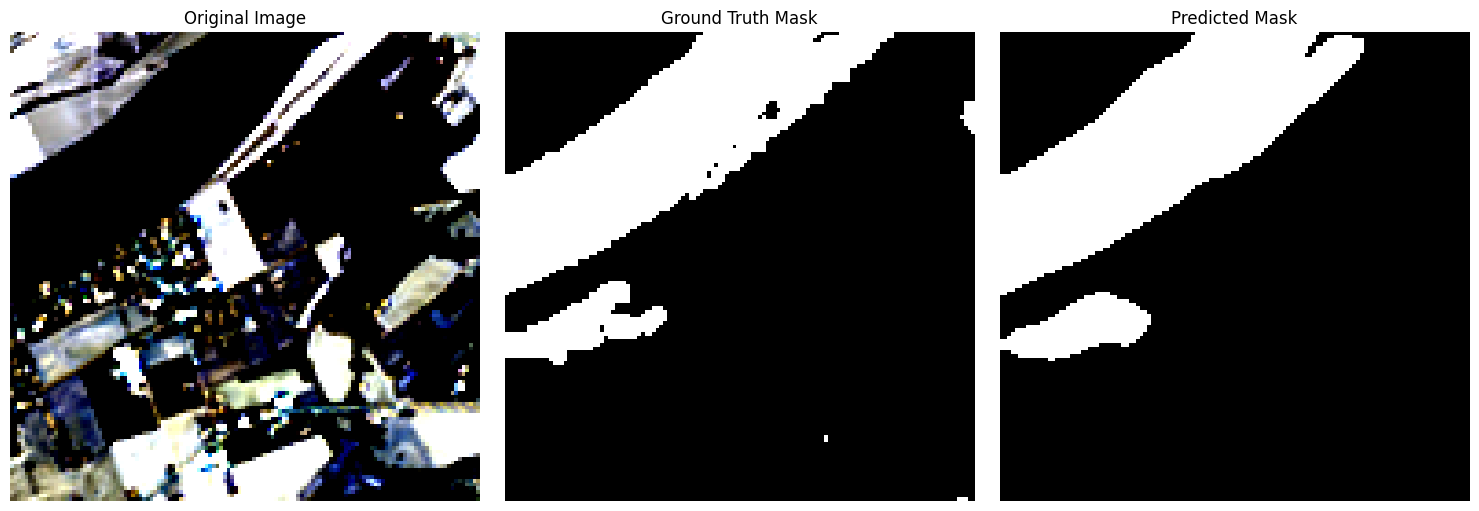

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


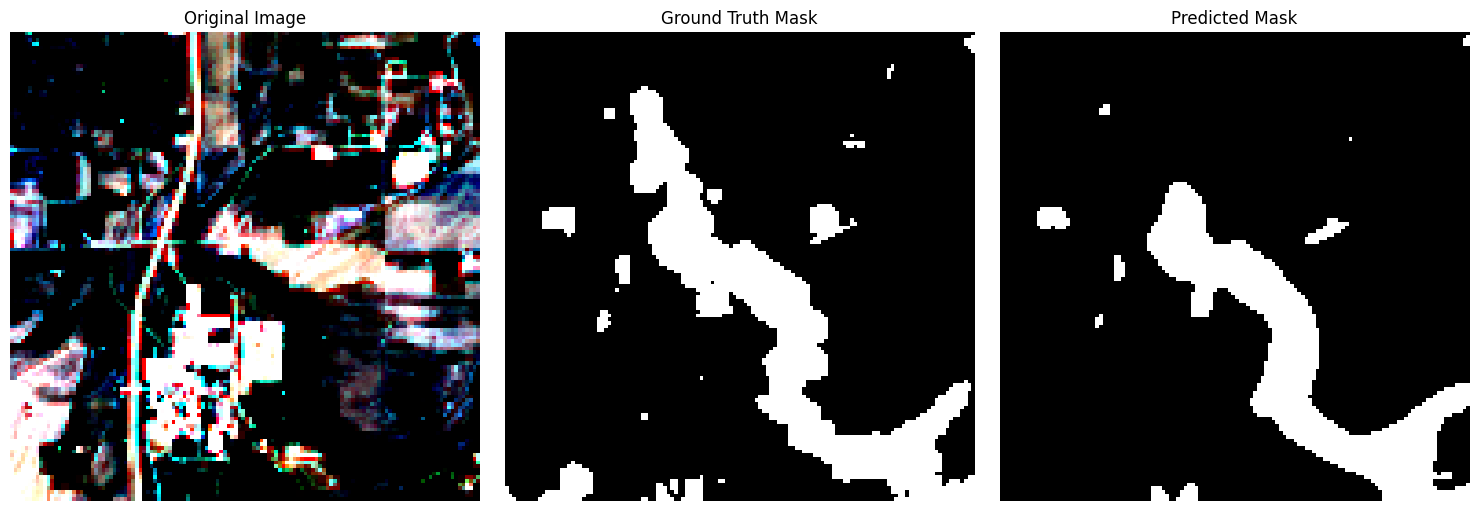

In [102]:
    print("\nVisualizing a few predictions...")
    num_predictions_to_show = 3
    for i in range(num_predictions_to_show):
        sample_val_img = np.expand_dims(X_val[i], axis=0)
        predicted_mask = model.predict(sample_val_img)[0]
        
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.imshow(X_val[i][:, :, :3]) 
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(np.squeeze(y_val[i]), cmap='gray')
        plt.title('Ground Truth Mask')
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.imshow(np.squeeze(predicted_mask > 0.5), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()